In [1]:
import pandas as pd
import re
import pickle

In [2]:
# get today's over/under for each team from draftkings
df = pd.read_html("https://sportsbook.draftkings.com/leagues/basketball/nba")

# potential problem could occur if draft kings changes format of their html
df = df[0]

# rename column to today instead of tomorrow
# happens due to weird time zone issue when loading in data
df.rename(columns={"Tomorrow": "Today"}, inplace=True)

In [4]:
# function to separate date from team name
def split_team_name(team_and_date_long_string):
    """Splits up the messy "tomorrow" column from our scraped Draft Kings Data.
    Returns time, team abbreviation, and team name."""


    # find date - should be any characters ending with AM or PM
    # NOTE: game times appear to be 5 hours ahead of EST
    # not an issue unless we choose to implement this as a feature
    time = re.search(r'(.+)(AM|PM)', team_and_date_long_string)
    if not time:
        # if game is in progress, ignore
        return None, None, None
    
    time = time[0]
    # find team name - all characters after the date
    team = re.search(r'(.+)(AM|PM)(.+)', team_and_date_long_string)[3]

    # split abbreviation and team name
    team_abbrev = team.split(' ')[0]
    team_full = team.split(' ')[1]

    return time, team_abbrev, team_full

df[["time", "team_abbrev", "team_full"]] = df.apply(lambda x: split_team_name(x["Today"]), axis=1, result_type="expand")
df.dropna(inplace=True)

In [13]:
# convert team abbrev to 3 letters if its not

def expand_abbrev(abbrev, name):
    if name == "Lakers":
        return 'LAL'
    if name == "Knicks":
        return 'NYK'
    if name == "Clippers":
        return 'LAC'
    if name == "Spurs":
        return 'SAS'
    if name ==  "Nets":
        return 'BRK'
    else:
        return abbrev

df["team_abbrev"] = df.apply(lambda x: expand_abbrev(x["team_abbrev"], x["team_full"]), axis=1)

In [14]:
team = df.team_abbrev.iloc[0]

In [15]:
# from nba_api.stats.static import teams

# nba_teams = teams.get_teams()
# # Select the dictionary for the Celtics, which contains their team ID
# celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
# celtics_id = celtics['id']

In [16]:
# #this cell is ideal, but times out
# from nba_api.stats.endpoints import leaguegamefinder

# # Query for games where the Celtics were playing
# gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# # The first DataFrame of those returned is what we want.
# games = gamefinder.get_data_frames()[0]

# # filter games df to only current nba season

# games.head()

In [17]:
games = df.copy()

In [18]:
team

'BRK'

In [82]:
#team = df.team_abbrev.iloc[0]
team = "BOS"

# scrape from basketball reference
df = pd.read_html(f"https://www.basketball-reference.com/teams/{team}/2023_games.html")

df = df[0]

In [84]:
df.dropna(subset={"Tm"}, inplace=True) # null scores haven't happened yet
df.drop(columns={"Unnamed: 3", "Unnamed: 4", "Unnamed: 8", "Notes"}, inplace=True) # drop columns we don't need
df = df[df["Date"] != "Date"] # remove header row showing up as a game


df.rename(columns={"Unnamed: 5": "Home", "Unnamed: 7": "Win"}, inplace=True)

/tmp/ipykernel_27885/2493726751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Unnamed: 5": "Home", "Unnamed: 7": "Win"}, inplace=True)


In [86]:
# rename every column in df so the name of the team precedes it
# this is so we can merge the two dataframes later
df.columns = [f"team1_{col}" if col != "Date" else col for col in df.columns]

In [78]:
# function to convert Home column to 0 or 1
def home_to_binary(home):
    if home == "@":
        return 0
    else:
        return 1

# function to convert Win column to 0 or 1
def win_to_binary(win):
    if win == "W":
        return 1
    else:
        return 0

# function to return day of week (first 3 letters) from date
def get_day_of_week(date):
    return date[:3]

df["Home"] = df.apply(lambda x: home_to_binary(x["Home"]), axis=1)
df["Win"] = df.apply(lambda x: win_to_binary(x["Win"]), axis=1)
df["Day"] = df.apply(lambda x: get_day_of_week(x["Date"]), axis=1)

# set data types
df["Tm"] = df["Tm"].astype(int)
df["Opp"] = df["Opp"].astype(int)
df["W"] = df["W"].astype(int)
df["L"] = df["L"].astype(int)

## Function to find the matchups - should be in sets of two


In [72]:
# for example, the first matchup is team abbrev at index 0 and 1
# then 2 and 3, etc.
# we want a function that returns pairs of team names
def find_matchups(df):
    """Finds the matchups in the dataframe.
    Returns a list of tuples with the team abbreviations for each matchup."""
    matchups = []
    for i in range(0, len(df), 2):
        matchups.append((df.iloc[i]["team_abbrev"], df.iloc[i+1]["team_abbrev"]))
    return matchups

matchups = find_matchups(games)

# convert inner tuples to lists for mutability
matchups = [list(x) for x in matchups]

# insert "vs." in each list
for i in range(len(matchups)):
    matchups[i].insert(1, "vs.")

# turn each list into a string
matchups = [" ".join(x) for x in matchups]
matchups

In [77]:
pd.Series(matchups).to_csv("matchups.csv")

Bad pipe message: %s [b'\x1a\xef\xf9\x85xg\x0c\xbf\xc6k\t\xe8\xc2']
Bad pipe message: %s [b'\xb8%c \xaf\xe1\xb3\x98\x0c\x14K\xcf2\xea\x80\x8dz\xc1\x96\x9e\x84\xd8\xd6\xf3\x04Y\x11\xd6\xe1\xec\xafR\x8dPh\xe8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 h\xe9|\x86\xa5\x13\xa9\x0e\xb1f\x86\x13o=\xd8OM\xa5\x1cI\x9d\n']
Bad pipe message: %s [b'S_\x1ad\x1c\x8b\x918i`\xe9\x08V\xcbT6z\xee\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad']
Bad pipe message: %s [b"\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xa

In [22]:
# function to determine what time of day a game is
def get_time_of_day(time):
    if time in(["10:00a", "10:30a", "11:00a", "11:30a"]):
        return "Morning"
    if time in(["12:00p", "12:30p", "1:00p", "1:30p", "2:00p", "2:30p", "3:00p", "3:30p"]):
        return "Afternoon"
    if time in(["4:00p", "4:30p", "5:00p", "5:30p", "6:00p", "6:30p", "7:00p", "7:30p"]):
        return "Evening"
    if time in(["8:00p", "8:30p", "9:00p", "9:30p", "10:00p", "10:30p", "11:00p", "11:30p"]):
        return "Night"
    else:
        return "Unknown"

df["dow"] = df.apply(lambda x: get_time_of_day(x["Start (ET)"]), axis=1)


# convert day column to numeric
def day_to_numeric(day):
    if day == "Mon":
        return 1
    if day == "Tue":
        return 2
    if day == "Wed":
        return 3
    if day == "Thu":
        return 4
    if day == "Fri":
        return 5
    if day == "Sat":
        return 6
    if day == "Sun":
        return 7

df["Day"] = df.apply(lambda x: day_to_numeric(x["Day"]), axis=1)

/tmp/ipykernel_27885/4219075429.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

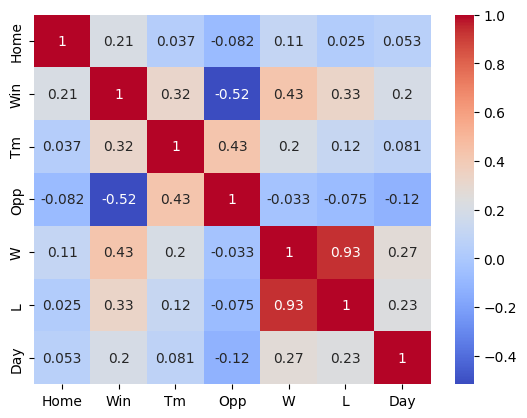

In [23]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [ ]:
# ohe for dow
df = pd.get_dummies(df, columns=["dow"], drop_first=True)